In [70]:
res = {}

## **dx, dy, dz, distance로 y_angle 예측**
 - Keras MLP       | MAE: 2.8204 | MSE: 89.6682
 - LinearRegression | MAE: 3.3502 | MSE: 102.1187

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info_final.csv')

# 🔧 피처 엔지니어링
df['dx'] = df['x_target'] - df['x_pos']
df['dy'] = df['y_target'] - df['y_pos']
df['dz'] = df['z_target'] - df['z_pos']
df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)

# 🔹 각도 정리: degree → radian → sin/cos
df[f'y_rad'] = np.deg2rad(df[f'y_angle'])
df[f'y_sin'] = np.sin(df[f'y_rad'])
df[f'y_cos'] = np.cos(df[f'y_rad'])
display(df.head())

# 입력(X), 출력(y)
X = df[['dx', 'dy', 'dz', 'distance']]
y = df[['y_sin', 'y_cos']]

# 🔄 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚖️ 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

,x_pos,y_pos,z_pos,x_angle,y_angle,x_target,y_target,z_target,dx,dy,dz,distance,y_rad,y_sin,y_cos
0,0.00,7.98,42.23,334.40,10.00,96.57908,7.773508,151.22130,96.57908,-0.206492,108.99130,145.625083,0.174533,0.173648,0.984808
1,0.00,7.98,39.63,54.72,10.00,26.68355,7.741399,144.31480,26.68355,-0.238601,104.68480,108.032292,0.174533,0.173648,0.984808
2,6.03,7.97,45.15,161.33,-4.12,13.32130,7.917756,18.49203,7.29130,-0.052244,-26.65797,27.637170,-0.071908,-0.071846,0.997416
3,74.04,7.97,129.11,45.33,-5.00,88.44806,7.904514,142.24230,14.40806,-0.065486,13.13230,19.494968,-0.087266,-0.087156,0.996195
4,158.52,8.00,233.38,267.27,8.29,60.68079,7.784992,245.00810,-97.83921,-0.215008,11.62810,98.528016,0.144688,0.144183,0.989551


In [72]:
# 🔹 유틸 함수
def recover_angles(y_pred):
    y_sin, y_cos = y_pred[:, 0], y_pred[:, 1]
    y_angle = np.rad2deg(np.arctan2(y_sin, y_cos)) % 360
    return np.stack([y_angle], axis=1)

def angle_mae(y_true_deg, y_pred_deg):
    error = np.abs((y_true_deg - y_pred_deg + 180) % 360 - 180)
    return np.mean(error), np.mean(error**2)

def convert_to_signed_angle(angle_deg):
    # 0~360도 범위의 각도를 -5~10도로 변환:
    # - 355~359도는 -5~-1도로 간주
    # - 나머지는 그대로 유지
    angle_deg = np.array(angle_deg)
    angle_deg[angle_deg >= 354] -= 360
    return angle_deg

# 🔹 결과 저장
results = {}
predictions = {}

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred_deg = convert_to_signed_angle(recover_angles(y_pred))
y_true_deg = convert_to_signed_angle(recover_angles(y_test.values))
mae, mse = angle_mae(y_true_deg, y_pred_deg)
results['LinearRegression'] = {'mae': mae, 'mse': mse}
predictions['LinearRegression'] = y_pred_deg

# 🔸 Keras 모델
def build_keras_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)  # sin/cos for y
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

keras_model = build_keras_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

keras_model.fit(
    X_train_scaled, y_train.values,
    validation_split=0.2,
    epochs=200,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=0
)

y_pred_keras = keras_model.predict(X_test_scaled, verbose=0)
y_pred_keras_deg = convert_to_signed_angle(recover_angles(y_pred_keras))
y_true_deg = convert_to_signed_angle(recover_angles(y_test.values))
mae, mse = angle_mae(y_true_deg, y_pred_keras_deg)
results['Keras MLP'] = {'mae': mae, 'mse': mse}
predictions['Keras MLP'] = y_pred_keras_deg

# 📈 성능 정리
print("\n📊 모델 성능 비교 (MAE 기준 정렬):")
sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
for name, metrics in sorted_results:
    res[f'4 feature {name}'] = {'mae': mae, 'mse': mse}
    print(f"{name:15} | MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f}")


📊 모델 성능 비교 (MAE 기준 정렬):
Keras MLP       | MAE: 1.0171 | MSE: 1.7242
LinearRegression | MAE: 1.5389 | MSE: 3.8025


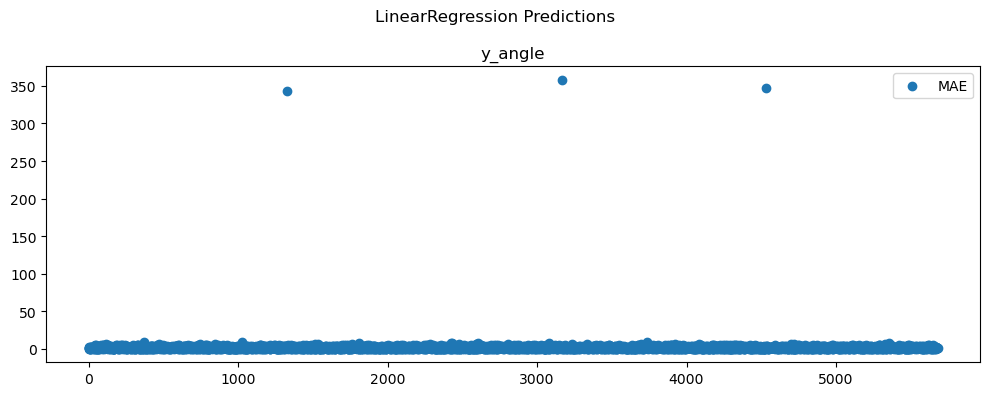

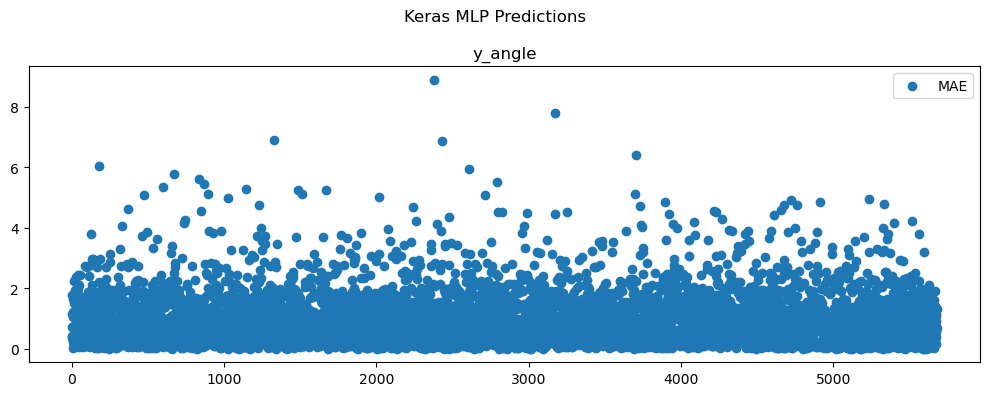

In [73]:
# 📉 시각화: 예측 vs 실제
for name, y_pred in predictions.items():
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'{name} Predictions')

    plt.scatter(range(len(y_pred)), abs(y_true_deg[:, 0] - y_pred[:, 0]), label='MAE')
    plt.title('y_angle')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [74]:
# 🔸 입력값 정의 240.61,23.96,75.97,171.01,-28.16,244.6352,15.32647,55.79445
input_data = [120.51, 13.47, 145.14, 135.46, 8.6, 276.87]

dx = input_data[0] - input_data[3]
dy = input_data[1] - input_data[4]
dz = input_data[2] - input_data[5]
dist = (dx**2 + dy**2 + dz**2)**0.5

input_data = np.array([[dx, dy, dz, dist]])

# 🔸 스케일링 (X_train_scaled 기준 스케일러 사용)
input_scaled = scaler.transform(input_data)

# 🔸 예측
y_pred_raw = model.predict(input_scaled)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"LinearRegression 예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

# 🔸 예측
y_pred_raw = keras_model.predict(input_scaled, verbose=0)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"Keras 예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

LinearRegression 예측된 각도 (deg): y_angle = 5.78°
Keras 예측된 각도 (deg): y_angle = 5.04°


/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## **dy, distance로 y_angle 예측**
 - Keras MLP       | MAE: 0.8267 | MSE: 1.4997
 - LinearRegression | MAE: 1.5388 | MSE: 3.8018

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 🔹 데이터 로드
df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info_final.csv')

# 🔹 피처 엔지니어링
df['dx'] = df['x_target'] - df['x_pos']
df['dy'] = df['y_target'] - df['y_pos']
df['dz'] = df['z_target'] - df['z_pos']
df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)

# 🔹 각도 정리: degree → radian → sin/cos
df[f'y_rad'] = np.deg2rad(df[f'y_angle'])
df[f'y_sin'] = np.sin(df[f'y_rad'])
df[f'y_cos'] = np.cos(df[f'y_rad'])
display(df.head())

# 🔹 입력(X), 출력(y)
X = df[['dy', 'distance']]
y = df[['y_sin', 'y_cos']]

# 🔹 데이터 분할 및 정규화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

,x_pos,y_pos,z_pos,x_angle,y_angle,x_target,y_target,z_target,dx,dy,dz,distance,y_rad,y_sin,y_cos
0,0.00,7.98,42.23,334.40,10.00,96.57908,7.773508,151.22130,96.57908,-0.206492,108.99130,145.625083,0.174533,0.173648,0.984808
1,0.00,7.98,39.63,54.72,10.00,26.68355,7.741399,144.31480,26.68355,-0.238601,104.68480,108.032292,0.174533,0.173648,0.984808
2,6.03,7.97,45.15,161.33,-4.12,13.32130,7.917756,18.49203,7.29130,-0.052244,-26.65797,27.637170,-0.071908,-0.071846,0.997416
3,74.04,7.97,129.11,45.33,-5.00,88.44806,7.904514,142.24230,14.40806,-0.065486,13.13230,19.494968,-0.087266,-0.087156,0.996195
4,158.52,8.00,233.38,267.27,8.29,60.68079,7.784992,245.00810,-97.83921,-0.215008,11.62810,98.528016,0.144688,0.144183,0.989551


In [76]:
# 🔹 유틸 함수
def recover_angles(y_pred):
    y_sin, y_cos = y_pred[:, 0], y_pred[:, 1]
    y_angle = np.rad2deg(np.arctan2(y_sin, y_cos)) % 360
    return np.stack([y_angle], axis=1)

def angle_mae(y_true_deg, y_pred_deg):
    error = np.abs((y_true_deg - y_pred_deg + 180) % 360 - 180)
    return np.mean(error), np.mean(error**2)

def convert_to_signed_angle(angle_deg):
    # 0~360도 범위의 각도를 -5~10도로 변환:
    # - 355~359도는 -5~-1도로 간주
    # - 나머지는 그대로 유지
    angle_deg = np.array(angle_deg)
    angle_deg[angle_deg >= 354] -= 360
    return angle_deg

# 🔹 결과 저장
results = {}
predictions = {}

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred_deg = convert_to_signed_angle(recover_angles(y_pred))
y_true_deg = convert_to_signed_angle(recover_angles(y_test.values))
mae, mse = angle_mae(y_true_deg, y_pred_deg)
results['LinearRegression'] = {'mae': mae, 'mse': mse}
predictions['LinearRegression'] = y_pred_deg

# 🔸 Keras 모델
def build_keras_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)  # sin/cos for y
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

keras_model = build_keras_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

keras_model.fit(
    X_train_scaled, y_train.values,
    validation_split=0.2,
    epochs=200,
    batch_size=512,
    callbacks=[early_stop],
    verbose=0
)

y_pred_keras = keras_model.predict(X_test_scaled, verbose=0)
y_pred_keras_deg = convert_to_signed_angle(recover_angles(y_pred_keras))
y_true_deg = convert_to_signed_angle(recover_angles(y_test.values))
mae, mse = angle_mae(y_true_deg, y_pred_keras_deg)
results['Keras MLP'] = {'mae': mae, 'mse': mse}
predictions['Keras MLP'] = y_pred_keras_deg

# 📈 성능 정리
print("\n📊 모델 성능 비교 (MAE 기준 정렬):")
sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
for name, metrics in sorted_results:
    res[f'2 feature {name}'] = {'mae': mae, 'mse': mse}
    print(f"{name:15} | MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f}")


📊 모델 성능 비교 (MAE 기준 정렬):
Keras MLP       | MAE: 0.9188 | MSE: 1.5841
LinearRegression | MAE: 1.5388 | MSE: 3.8018


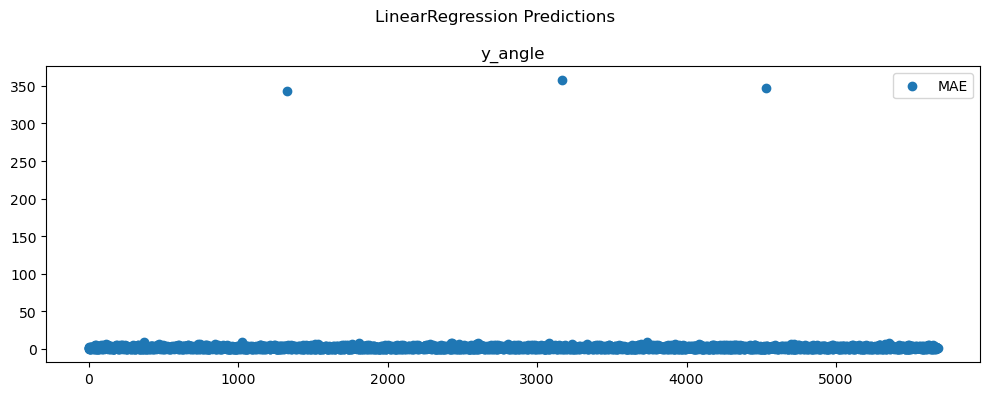

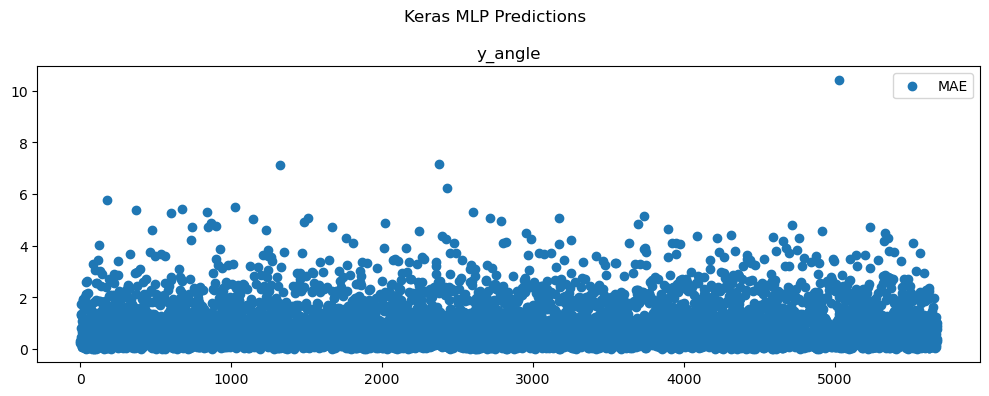

In [77]:
# 📉 시각화: 예측 vs 실제
for name, y_pred in predictions.items():
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'{name} Predictions')

    plt.scatter(range(len(y_pred)), abs(y_true_deg[:, 0] - y_pred[:, 0]), label='MAE')
    plt.title('y_angle')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [78]:
# 🔸 입력값 정의 240.61,23.96,75.97,171.01,-28.16,244.6352,15.32647,55.79445
input_data = [120.51, 13.47, 145.14, 135.46, 8.6, 276.87]

dx = input_data[0] - input_data[3]
dy = input_data[1] - input_data[4]
dz = input_data[2] - input_data[5]
dist = (dx**2 + dy**2 + dz**2)**0.5

input_data = np.array([[dy, dist]])

# 🔸 스케일링 (X_train_scaled 기준 스케일러 사용)
input_scaled = scaler.transform(input_data)

# 🔸 예측
y_pred_raw = model.predict(input_scaled)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"LinearRegression 예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

# 🔸 예측
y_pred_raw = keras_model.predict(input_scaled, verbose=0)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"Keras 예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

LinearRegression 예측된 각도 (deg): y_angle = 5.68°
Keras 예측된 각도 (deg): y_angle = 5.54°


/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## **distance로 y_angle 예측**
 - Keras MLP       | MAE: 0.9310 | MSE: 1.6835
 - LinearRegression | MAE: 1.5399 | MSE: 3.8071

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 🔹 데이터 로드
df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info_final.csv')

# 🔹 피처 엔지니어링
df['dx'] = df['x_target'] - df['x_pos']
df['dy'] = df['y_target'] - df['y_pos']
df['dz'] = df['z_target'] - df['z_pos']
df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)

# 🔹 각도 정리: degree → radian → sin/cos
df[f'y_rad'] = np.deg2rad(df[f'y_angle'])
df[f'y_sin'] = np.sin(df[f'y_rad'])
df[f'y_cos'] = np.cos(df[f'y_rad'])
display(df.head())

# 🔹 입력(X), 출력(y)
X = df[['distance']]
y = df[['y_sin', 'y_cos']]

# 🔹 데이터 분할 및 정규화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

,x_pos,y_pos,z_pos,x_angle,y_angle,x_target,y_target,z_target,dx,dy,dz,distance,y_rad,y_sin,y_cos
0,0.00,7.98,42.23,334.40,10.00,96.57908,7.773508,151.22130,96.57908,-0.206492,108.99130,145.625083,0.174533,0.173648,0.984808
1,0.00,7.98,39.63,54.72,10.00,26.68355,7.741399,144.31480,26.68355,-0.238601,104.68480,108.032292,0.174533,0.173648,0.984808
2,6.03,7.97,45.15,161.33,-4.12,13.32130,7.917756,18.49203,7.29130,-0.052244,-26.65797,27.637170,-0.071908,-0.071846,0.997416
3,74.04,7.97,129.11,45.33,-5.00,88.44806,7.904514,142.24230,14.40806,-0.065486,13.13230,19.494968,-0.087266,-0.087156,0.996195
4,158.52,8.00,233.38,267.27,8.29,60.68079,7.784992,245.00810,-97.83921,-0.215008,11.62810,98.528016,0.144688,0.144183,0.989551


In [80]:
# 🔹 유틸 함수
def recover_angles(y_pred):
    y_sin, y_cos = y_pred[:, 0], y_pred[:, 1]
    y_angle = np.rad2deg(np.arctan2(y_sin, y_cos)) % 360
    return np.stack([y_angle], axis=1)

def angle_mae(y_true_deg, y_pred_deg):
    error = np.abs((y_true_deg - y_pred_deg + 180) % 360 - 180)
    return np.mean(error), np.mean(error**2)

def convert_to_signed_angle(angle_deg):
    # 0~360도 범위의 각도를 -5~10도로 변환:
    # - 355~359도는 -5~-1도로 간주
    # - 나머지는 그대로 유지
    angle_deg = np.array(angle_deg)
    angle_deg[angle_deg >= 354] -= 360
    return angle_deg

# 🔹 결과 저장
results = {}
predictions = {}

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred_deg = convert_to_signed_angle(recover_angles(y_pred))
y_true_deg = convert_to_signed_angle(recover_angles(y_test.values))
mae, mse = angle_mae(y_true_deg, y_pred_deg)
results['LinearRegression'] = {'mae': mae, 'mse': mse}
predictions['LinearRegression'] = y_pred_deg

# 🔸 Keras 모델
def build_keras_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)  # sin/cos for y
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

keras_model = build_keras_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

keras_model.fit(
    X_train_scaled, y_train.values,
    validation_split=0.2,
    epochs=200,
    batch_size=256,
    callbacks=[early_stop],
    verbose=0
)

y_pred_keras = keras_model.predict(X_test_scaled, verbose=0)
y_pred_keras_deg = convert_to_signed_angle(recover_angles(y_pred_keras))
y_true_deg = convert_to_signed_angle(recover_angles(y_test.values))
mae, mse = angle_mae(y_true_deg, y_pred_keras_deg)
results['Keras MLP'] = {'mae': mae, 'mse': mse}
predictions['Keras MLP'] = y_pred_keras_deg

# 📈 성능 정리
print("\n📊 모델 성능 비교 (MAE 기준 정렬):")
sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
for name, metrics in sorted_results:
    res[f'1 feature {name}'] = {'mae': mae, 'mse': mse}
    print(f"{name:15} | MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f}")


📊 모델 성능 비교 (MAE 기준 정렬):
Keras MLP       | MAE: 0.9267 | MSE: 1.7026
LinearRegression | MAE: 1.5399 | MSE: 3.8071


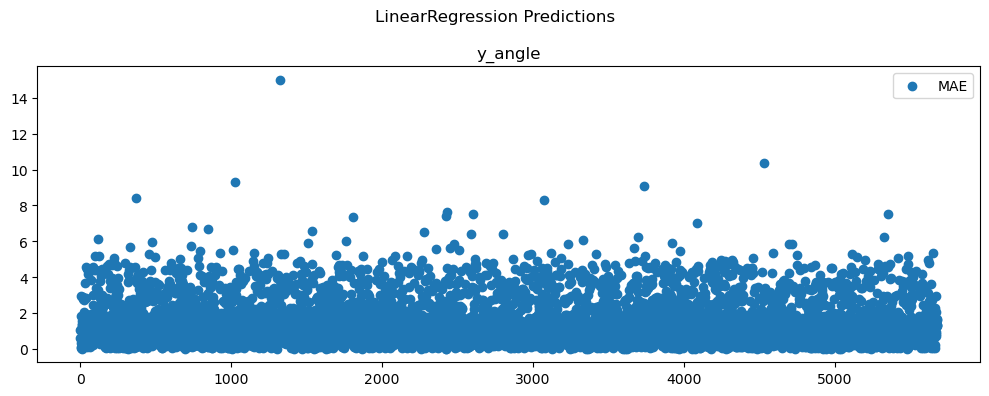

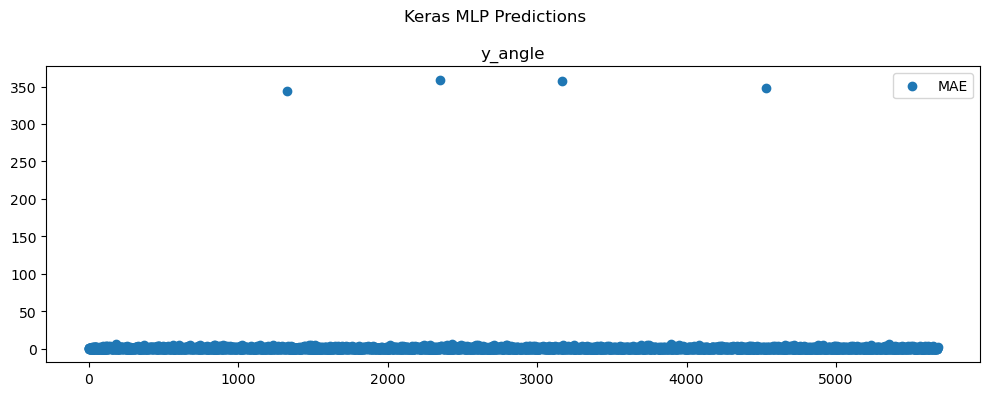

In [81]:
# 📉 시각화: 예측 vs 실제
for name, y_pred in predictions.items():
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'{name} Predictions')

    plt.scatter(range(len(y_pred)), abs(y_true_deg[:, 0] - y_pred[:, 0]), label='MAE')
    plt.title('y_angle')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [83]:
# 🔸 입력값 정의 240.61,23.96,75.97,171.01,-28.16,244.6352,15.32647,55.79445
input_data = [120.51, 13.47, 145.14, 135.46, 8.6, 276.87]

dx = input_data[0] - input_data[3]
dy = input_data[1] - input_data[4]
dz = input_data[2] - input_data[5]
dist = (dx**2 + dy**2 + dz**2)**0.5

input_data = np.array([[dist]])

# 🔸 스케일링 (X_train_scaled 기준 스케일러 사용)
input_scaled = scaler.transform(input_data)

# 🔸 예측
y_pred_raw = model.predict(input_scaled)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"LinearRegression 예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

# 🔸 예측
y_pred_raw = keras_model.predict(input_scaled, verbose=0)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"Keras 예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

LinearRegression 예측된 각도 (deg): y_angle = 10.00°
Keras 예측된 각도 (deg): y_angle = 8.91°


/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## **Under Sampling 후 dy, distance로 y_angle 예측**
 - Keras MLP       | MAE: 1.0341 | MSE: 1.8080
 - LinearRegression | MAE: 1.3720 | MSE: 3.2837

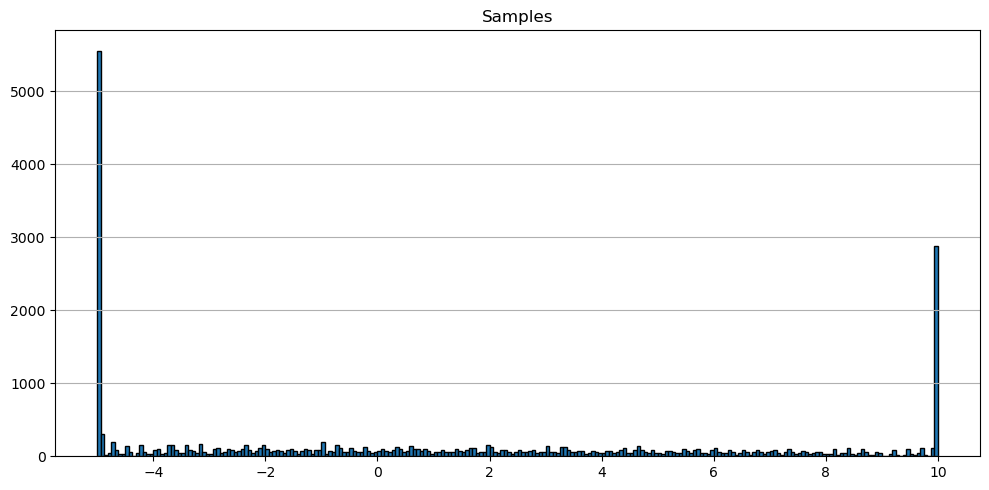

-5.0~-4.9375      5559
9.9375~10.0       2885
-4.9375~-4.875     303
1.9375~2.0         203
-4.75~-4.6875      175
Name: angle_bin, dtype: int64


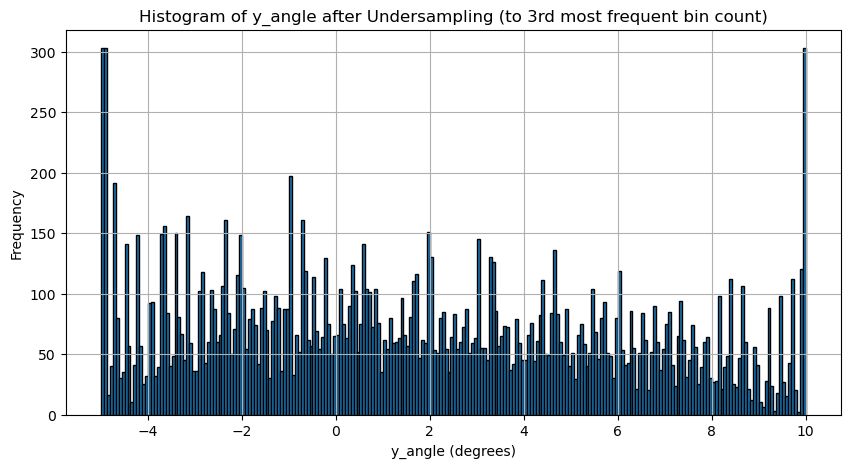

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 🔹 데이터 로드
df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info_final.csv')

# y_angle 열 기준
bins = np.linspace(-5, 10, 241)

plt.figure(figsize=(10, 5))
plt.hist(df['y_angle'], bins=bins, edgecolor='black')
plt.title("Samples")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 히스토그램 구간 설정 (-5 ~ 10도 사이 240개 구간)
bins = np.linspace(-5, 10, 241)
labels = [f'{round(bins[i],4)}~{round(bins[i+1],4)}' for i in range(len(bins)-1)]

# 각 샘플이 속한 구간 라벨 부여
df['angle_bin'] = pd.cut(df['y_angle'], bins=bins, labels=labels, include_lowest=True)

# 구간별 개수 확인
bin_counts = df['angle_bin'].value_counts().sort_values(ascending=False)
print(bin_counts.head())  # 상위 5개 확인

# 세 번째로 많은 bin의 개수
target_count = bin_counts.iloc[2]  # 세 번째로 많은 구간

# 구간별 샘플링
df_balanced = df.groupby('angle_bin', group_keys=False).apply(lambda x: x.sample(min(len(x), target_count), random_state=42))

plt.figure(figsize=(10, 5))
plt.hist(df_balanced['y_angle'], bins=bins, edgecolor='black')
plt.title('Histogram of y_angle after Undersampling (to 3rd most frequent bin count)')
plt.xlabel('y_angle (degrees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [85]:
# 🔹 피처 엔지니어링
df_balanced['dx'] = df_balanced['x_target'] - df_balanced['x_pos']
df_balanced['dy'] = df_balanced['y_target'] - df_balanced['y_pos']
df_balanced['dz'] = df_balanced['z_target'] - df_balanced['z_pos']
df_balanced['distance'] = np.sqrt(df_balanced['dx']**2 + df_balanced['dy']**2 + df_balanced['dz']**2)

# 🔹 각도 정리: degree → radian → sin/cos
df_balanced[f'y_rad'] = np.deg2rad(df_balanced[f'y_angle'])
df_balanced[f'y_sin'] = np.sin(df_balanced[f'y_rad'])
df_balanced[f'y_cos'] = np.cos(df_balanced[f'y_rad'])
display(df_balanced.head())
print(len(df_balanced))

# 🔹 입력(X), 출력(y)
X = df_balanced[['dy', 'distance']]
y = df_balanced[['y_sin', 'y_cos']]

# 🔹 데이터 분할 및 정규화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

,x_pos,y_pos,z_pos,x_angle,y_angle,x_target,y_target,z_target,angle_bin,dx,dy,dz,distance,y_rad,y_sin,y_cos
22028,119.42,7.97,245.90,30.63,-4.95,133.0979,7.914715,266.43140,-5.0~-4.9375,13.6779,-0.055285,20.53140,24.670354,-0.086394,-0.086286,0.996270
21850,185.68,7.98,51.00,183.49,-5.00,182.2199,7.923847,31.24769,-5.0~-4.9375,-3.4601,-0.056153,-19.75231,20.053159,-0.087266,-0.087156,0.996195
18903,248.25,7.98,169.70,321.06,-5.00,235.6319,7.895832,184.28380,-5.0~-4.9375,-12.6181,-0.084168,14.58380,19.284988,-0.087266,-0.087156,0.996195
487,45.32,7.99,15.28,346.82,-5.00,39.5047,7.906679,34.77036,-5.0~-4.9375,-5.8153,-0.083321,19.49036,20.339587,-0.087266,-0.087156,0.996195
2992,134.67,7.99,242.52,329.52,-4.98,124.4865,7.931821,259.77550,-5.0~-4.9375,-10.1835,-0.058179,17.25550,20.036450,-0.086917,-0.086808,0.996225


17256


In [86]:
# 🔹 유틸 함수
def recover_angles(y_pred):
    y_sin, y_cos = y_pred[:, 0], y_pred[:, 1]
    y_angle = np.rad2deg(np.arctan2(y_sin, y_cos)) % 360
    return np.stack([y_angle], axis=1)

def angle_mae(y_true_deg, y_pred_deg):
    error = np.abs((y_true_deg - y_pred_deg + 180) % 360 - 180)
    return np.mean(error), np.mean(error**2)

def convert_to_signed_angle(angle_deg):
    # 0~360도 범위의 각도를 -5~10도로 변환:
    # - 355~359도는 -5~-1도로 간주
    # - 나머지는 그대로 유지
    angle_deg = np.array(angle_deg)
    angle_deg[angle_deg >= 354] -= 360
    return angle_deg

# 🔹 결과 저장
results = {}
predictions = {}

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred_deg = convert_to_signed_angle(recover_angles(y_pred))
y_true_deg = convert_to_signed_angle(recover_angles(y_test.values))
mae, mse = angle_mae(y_true_deg, y_pred_deg)
results['LinearRegression'] = {'mae': mae, 'mse': mse}
predictions['LinearRegression'] = y_pred_deg

# 🔸 Keras 모델
def build_keras_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)  # sin/cos for y
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

keras_model = build_keras_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

keras_model.fit(
    X_train_scaled, y_train.values,
    validation_split=0.2,
    epochs=200,
    batch_size=512,
    callbacks=[early_stop],
    verbose=0
)

y_pred_keras = keras_model.predict(X_test_scaled, verbose=0)
y_pred_keras_deg = convert_to_signed_angle(recover_angles(y_pred_keras))
y_true_deg = convert_to_signed_angle(recover_angles(y_test.values))
mae, mse = angle_mae(y_true_deg, y_pred_keras_deg)
results['Keras MLP'] = {'mae': mae, 'mse': mse}
predictions['Keras MLP'] = y_pred_keras_deg

# 📈 성능 정리
print("\n📊 모델 성능 비교 (MAE 기준 정렬):")
sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
for name, metrics in sorted_results:
    res[f'UnderSampled 2 feature {name}'] = {'mae': mae, 'mse': mse}
    print(f"{name:15} | MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f}")


📊 모델 성능 비교 (MAE 기준 정렬):
Keras MLP       | MAE: 1.0546 | MSE: 1.8489
LinearRegression | MAE: 1.3720 | MSE: 3.2837


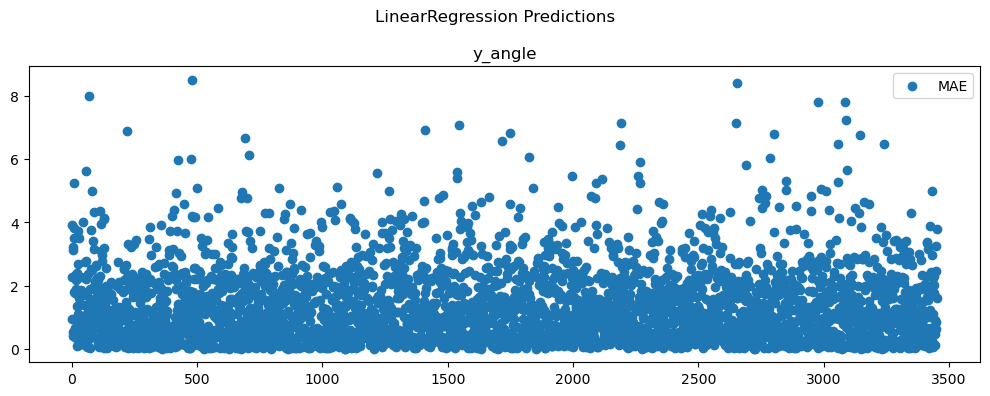

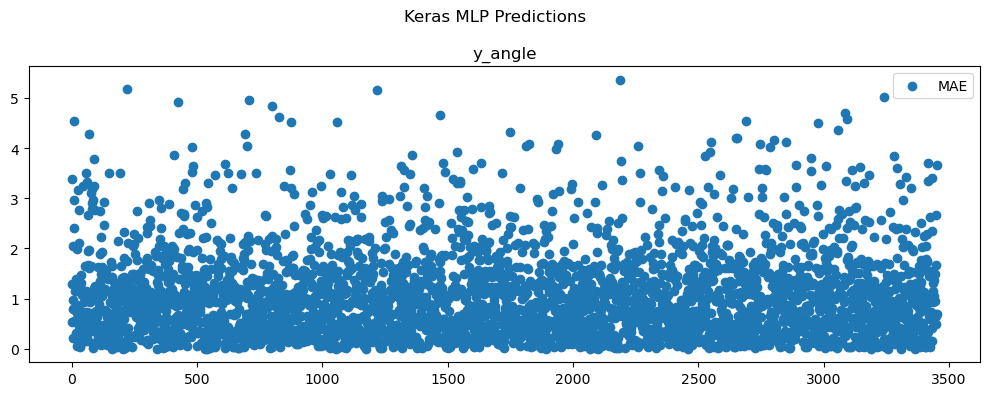

In [87]:
# 📉 시각화: 예측 vs 실제
for name, y_pred in predictions.items():
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'{name} Predictions')

    plt.scatter(range(len(y_pred)), abs(y_true_deg[:, 0] - y_pred[:, 0]), label='MAE')
    plt.title('y_angle')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [88]:
# 🔸 입력값 정의 240.61,23.96,75.97,171.01,-28.16,244.6352,15.32647,55.79445
input_data = [120.51, 13.47, 145.14, 135.46, 8.6, 276.87]

dx = input_data[0] - input_data[3]
dy = input_data[1] - input_data[4]
dz = input_data[2] - input_data[5]
dist = (dx**2 + dy**2 + dz**2)**0.5

input_data = np.array([[dy, dist]])

# 🔸 스케일링 (X_train_scaled 기준 스케일러 사용)
input_scaled = scaler.transform(input_data)

# 🔸 예측
y_pred_raw = model.predict(input_scaled)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"LinearRegression 예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

# 🔸 예측
y_pred_raw = keras_model.predict(input_scaled, verbose=0)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"Keras 예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

LinearRegression 예측된 각도 (deg): y_angle = 11.23°
Keras 예측된 각도 (deg): y_angle = 7.02°


/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ✅ 데이터 로드 및 전처리
df = pd.read_csv("turret_info_final.csv")
df['y_sin'] = np.sin(np.deg2rad(df['y_angle']))
df['y_cos'] = np.cos(np.deg2rad(df['y_angle']))
df['distance'] = np.sqrt((df['x_pos'] - df['x_target'])**2 +
                         (df['y_pos'] - df['y_target'])**2 +
                         (df['z_pos'] - df['z_target'])**2)
df['dy'] = df['y_pos'] - df['y_target']

X = df[['distance', 'dy']].values
y = df[['y_sin', 'y_cos']].values

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ✅ 각도 변환 함수
def to_deg(y_vec):
    return np.rad2deg(np.arctan2(y_vec[:, 0], y_vec[:, 1]))

# ✅ 평가 함수
def evaluate(true, pred):
    true_deg = to_deg(true)
    pred_deg = to_deg(pred)
    return mean_absolute_error(true_deg, pred_deg)

# ✅ Optuna 목적 함수
def objective(trial):
    # DNN
    dnn_units = trial.suggest_int("dnn_units", 32, 128)
    dnn_lr = trial.suggest_float("dnn_lr", 1e-5, 1e-2, log=True)

    # XGBoost
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 300)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 6)
    xgb_lr = trial.suggest_float("xgb_lr", 0.01, 0.3, log=True)

    # LightGBM
    lgb_n_estimators = trial.suggest_int("lgb_n_estimators", 100, 300)
    lgb_max_depth = trial.suggest_int("lgb_max_depth", 3, 6)
    lgb_lr = trial.suggest_float("lgb_lr", 0.01, 0.3, log=True)

    # ✅ DNN
    dnn_model = Sequential([
        Dense(dnn_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(dnn_units, activation='relu'),
        Dense(2)
    ])
    dnn_model.compile(optimizer=Adam(dnn_lr), loss=Huber())
    dnn_model.fit(X_train, y_train,
                  epochs=200,
                  batch_size=1024,
                  validation_split=0.2,
                  verbose=0,
                  callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

    y_pred_dnn = dnn_model.predict(X_test, verbose=0)

    # ✅ XGBoost
    xgb_model = MultiOutputRegressor(XGBRegressor(
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        learning_rate=xgb_lr,
        verbosity=0
    ))
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    # ✅ LightGBM
    lgb_model = MultiOutputRegressor(LGBMRegressor(
        n_estimators=lgb_n_estimators,
        max_depth=lgb_max_depth,
        learning_rate=lgb_lr
    ))
    lgb_model.fit(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_test)

    # ✅ 앙상블
    y_pred_ens = (y_pred_dnn + y_pred_xgb + y_pred_lgb) / 3

    return evaluate(y_test, y_pred_ens)

# ✅ Optuna 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# ✅ 최적 하이퍼파라미터 출력
print("🎯 Best Trial:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")


ModuleNotFoundError: No module named 'lightgbm'

## **모델별 오차 비교**

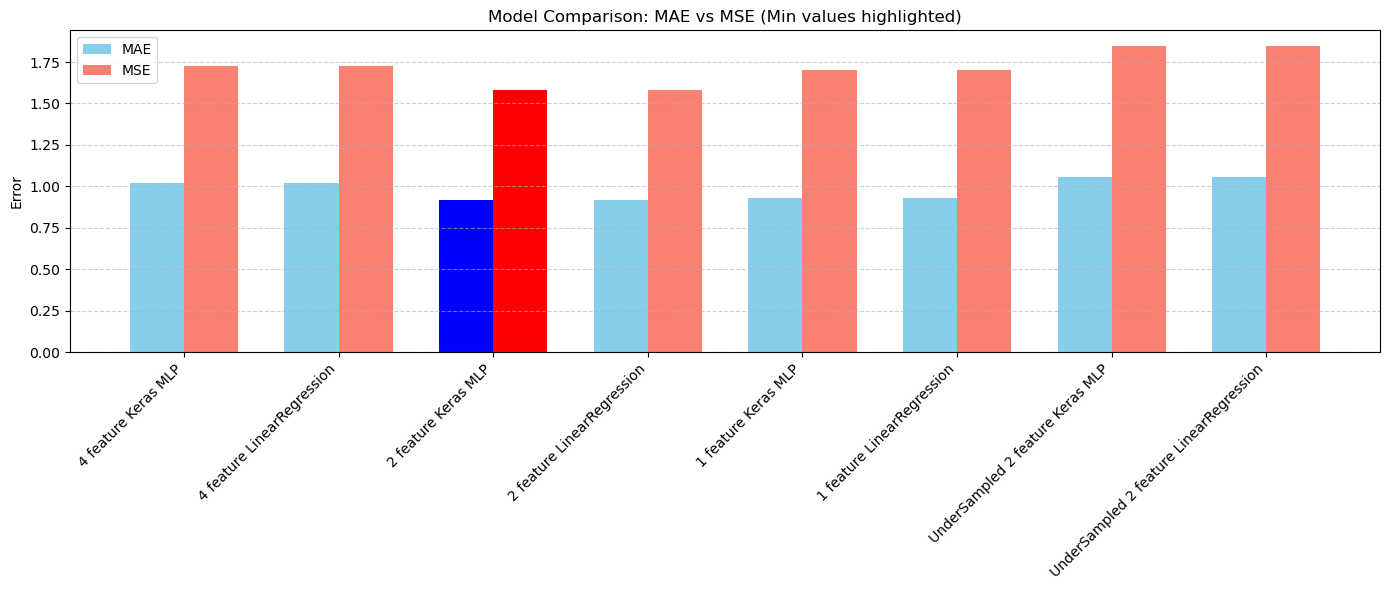

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# 모델명, MAE, MSE 분리
model_names = list(res.keys())
mae_values = [res[m]['mae'] for m in model_names]
mse_values = [res[m]['mse'] for m in model_names]

# 최소값 위치
min_mae_idx = np.argmin(mae_values)
min_mse_idx = np.argmin(mse_values)

x = np.arange(len(model_names))
width = 0.35

# 색상 설정
mae_colors = ['skyblue'] * len(model_names)
mse_colors = ['salmon'] * len(model_names)
mae_colors[min_mae_idx] = 'blue'     # MAE 최소값 강조
mse_colors[min_mse_idx] = 'red'      # MSE 최소값 강조

# 📊 시각화
plt.figure(figsize=(14, 6))
plt.bar(x - width/2, mae_values, width, label='MAE', color=mae_colors)
plt.bar(x + width/2, mse_values, width, label='MSE', color=mse_colors)

plt.xticks(x, model_names, rotation=45, ha='right')
plt.ylabel("Error")
plt.title("Model Comparison: MAE vs MSE (Min values highlighted)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
